In [1]:
!pip install rasterio
!pip install fiona
!pip install shapely
!pip install geopandas
!pip install pycrs

     ---------------------------------------- 0.0/22.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/22.0 MB ? eta -:--:--
     ---------------------------------------- 0.1/22.0 MB 1.8 MB/s eta 0:00:13
      --------------------------------------- 0.5/22.0 MB 3.6 MB/s eta 0:00:06
     -- ------------------------------------- 1.2/22.0 MB 7.8 MB/s eta 0:00:03
     --- ------------------------------------ 2.0/22.0 MB 9.8 MB/s eta 0:00:03
     ---- ----------------------------------- 2.5/22.0 MB 10.6 MB/s eta 0:00:02
     ----- ---------------------------------- 3.1/22.0 MB 11.0 MB/s eta 0:00:02
     ----- ---------------------------------- 3.1/22.0 MB 9.5 MB/s eta 0:00:02
     ----- ---------------------------------- 3.1/22.0 MB 9.5 MB/s eta 0:00:02
     ----- ---------------------------------- 3.1/22.0 MB 7.4 MB/s eta 0:00:03
     ----- ---------------------------------- 3.1/22.0 MB 7.4 MB/s eta 0:00:03
     ----- ---------------------------------- 3.1/22.0 MB 7.4 MB

In [17]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib import ticker
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import re #used for making multiple string splits
import json
import os

from matplotlib.colors import ListedColormap
import numpy as np

In [18]:
#load input file
# fp = r'cgls_landcover_2015_classification.tiff'
# fp = "dataPreprocessing/precipitationData/my_test_data.tif"
fp = "dataPreprocessing/temperatureData/tiffTemperatureData/LST2017_avg.tiff"
data = rasterio.open(fp)



In [19]:
def show_land_cover(img):
    #labels for plotting
    labels = {0: {'color': '#282828', 'flag': 'unknown'},
              20: {'color': '#FFBB22', 'flag': 'shrubs'},
              30: {'color': '#FFFF4C', 'flag': 'herbaceous_vegetation'},
              40: {'color': '#F096FF', 'flag': 'cultivated_and_managed_vegetation_or_agriculture'},
              50: {'color': '#FA0000', 'flag': 'urban_or_built_up'},
              60: {'color': '#B4B4B4', 'flag': 'bare_or_sparse_vegetation'},
              70: {'color': '#F0F0F0', 'flag': 'snow_and_ice'},
              80: {'color': '#0032C8', 'flag': 'permanent_water_bodies'},
              90: {'color': '#0096A0', 'flag': 'herbaceous_wetland'},
              100: {'color': '#FAE6A0', 'flag': 'moss_and_lichen'},
              111: {'color': '#58481F', 'flag': 'closed_forest_evergreen_needle_leaf'},
              112: {'color': '#009900', 'flag': 'closed_forest_evergreen_broad_leaf'},
              113: {'color': '#70663E', 'flag': 'closed_forest_deciduous_needle_leaf'},
              114: {'color': '#00CC00', 'flag': 'closed_forest_deciduous_broad_leaf'},
              115: {'color': '#4E751F', 'flag': 'closed_forest_mixed'},
              116: {'color': '#007800', 'flag': 'closed_forest_not_matching_any_of_the_other_definitions'},
              121: {'color': '#666000', 'flag': 'open_forest_evergreen_needle_leaf'},
              122: {'color': '#8DB400', 'flag': 'open_forest_evergreen_broad_leaf'},
              123: {'color': '#8D7400', 'flag': 'open_forest_deciduous_needle_leaf'},
              124: {'color': '#A0DC00', 'flag': 'open_forest_deciduous_broad_leaf'},
              125: {'color': '#929900', 'flag': 'open_forest_mixed'},
              126: {'color': '#648C00', 'flag': 'open_forest_not_matching_any_of_the_other_definitions'},
              200: {'color': '#000080', 'flag': 'oceans_seas'}}
    #colors1 = [label['color'] for label in labels.values()]
    cmap = ListedColormap([label['color'] for label in labels.values()])
    norm = colors.BoundaryNorm(list(labels.keys())+[201], cmap.N+1, extend='max')
    ticks = list(np.mean((list(list(labels.keys())+[201])[i+1], val)) for i, val in enumerate(list(labels.keys())))
    cblabels=[label['flag'] for label in labels.values()]
    
    #file setup
    img_name, _ = img.split("_")
    img_name = img_name + ".tiff"
    print(img_name)
    
    data = None
    with rasterio.open("landcover/"+img_name) as src:
        data = src.read()
        src.close() # close the rasterio dataset
    
    data_array = np.array(data)
    print(np.amin(data_array), np.amax(data_array))
#     print(np.around(data_array, 1))
    data_array = data_array[0,:,:]
    arr = data_array
#     arr = data_array * 0.02 - 273.15 #convert to celcius
    print(np.around(arr, 1))
    plt.imshow(arr)
    plt.show()
        
#     src = rasterio.open("landcover/"+img_name)
#     data = src.read()
    
    fig, ax = plt.subplots()

    cb = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=200.5), cmap=cmap), ax=ax)
    tick_locator = ticker.FixedLocator(locs=[(i*(200/23)+5) for i in range(len(ticks))])
    cb.locator = tick_locator
    cb.update_ticks()
    cb.set_ticklabels(cblabels[::-1])

    show(data, ax=ax, cmap=cmap, norm=norm) #transform=src.transform
    
    src.close()

In [20]:
#inspiration from https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html
def generate_land_cover_image(satellite_image_name, input_file, view=0.01):
    out_name, coordinates = satellite_image_name.split("_")
    out_name = out_name + ".tiff"
    lat, lon = re.split(", |.png|,", coordinates)[:2]
    lat = float(lat)
    lon = float(lon)
    
    #finding the bounding box of the center coordinate
    up_rightX, up_rightY = round(lat-view,4), round(lon+view,4)
    down_leftX, down_leftY = round(lat+view,4), round(lon-view,4)
    bbox = box(up_rightX,up_rightY,down_leftX,down_leftY)
    print("bbox", bbox)
    
    #Insert the BB to a GeoDataFrame and reproject it into the coordinate system of the input image
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
    geo = geo.to_crs(crs=data.crs.data)
    
    #Now we can receive the coordinates in the format that rasterio needs. 
    coords = [json.loads(geo.to_json())['features'][0]['geometry']]
    
    #Clips the data with the defined polygon
    out_img, out_transform = mask(input_file, shapes=coords, all_touched=True, crop=True)
    
    #Updating the metadata
    out_meta = data.meta.copy()
    print(out_meta)
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                  "height": out_img.shape[1],
                  "width": out_img.shape[2],
                  "transform": out_transform,
                  "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()
                   })
    
    #Writing the clipped image
    filepath = "./landcover/"+out_name
    if os.path.exists(filepath):
        os.remove(filepath) # delete the file 
    with rasterio.open(filepath, "w", **out_meta) as dest:
        dest.write(out_img)
        dest.close() # close the rasterio dataset
        

Manual testing

<open DatasetReader name='dataPreprocessing/temperatureData/tiffTemperatureData/LST2015_avg.tiff' mode='r'> <open DatasetReader name='dataPreprocessing/temperatureData/tiffTemperatureData/LST2015_avg.tiff' mode='r'>
bbox POLYGON ((2008.8124 2003.7315, 2008.8124 -1996.2685, -1991.1876 -1996.2685, -1991.1876 2003.7315, 2008.8124 2003.7315))


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1478343277.py:11: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=file, input_file = data, view=2000) #6_28.7472, -16.504.png
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
200.tiff
0.0 16515.326
[[    0.      0.      0.  ... 15302.2 15316.9 15307.1]
 [    0.      0.      0.  ... 15311.  15341.4 15337.2]
 [    0.      0.      0.  ... 15305.  15305.  15316.5]
 ...
 [    0.      0.      0.  ...     0.      0.      0. ]
 [    0.      0.      0.  ...     0.      0.      0. ]
 [    0.      0.      0.  ...     0.      0.      0. ]]


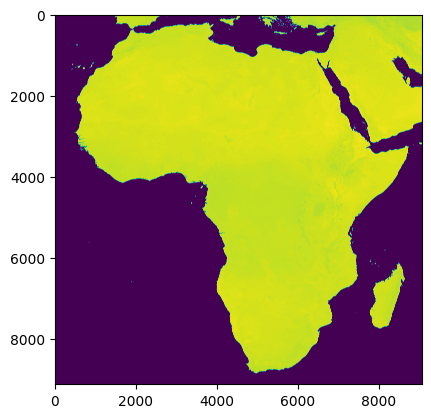

bbox POLYGON ((18.8124 13.7315, 18.8124 -6.2685, -1.1876 -6.2685, -1.1876 13.7315, 18.8124 13.7315))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1478343277.py:13: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=file, input_file = data, view=10) #6_28.7472, -16.504.png
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


200.tiff
0.0 15800.881
[[15385.7 15463.4 15491.2 ... 15698.6 15697.4 15697.4]
 [15363.5 15410.5 15438.8 ... 15686.  15689.1 15673.6]
 [15430.1 15440.2 15445.5 ... 15668.3 15656.3 15642.8]
 ...
 [    0.      0.      0.  ... 15118.  15122.2 15155.4]
 [    0.      0.      0.  ... 15144.  15135.5 15156.6]
 [    0.      0.      0.  ... 15140.4 15140.4 15129.8]]


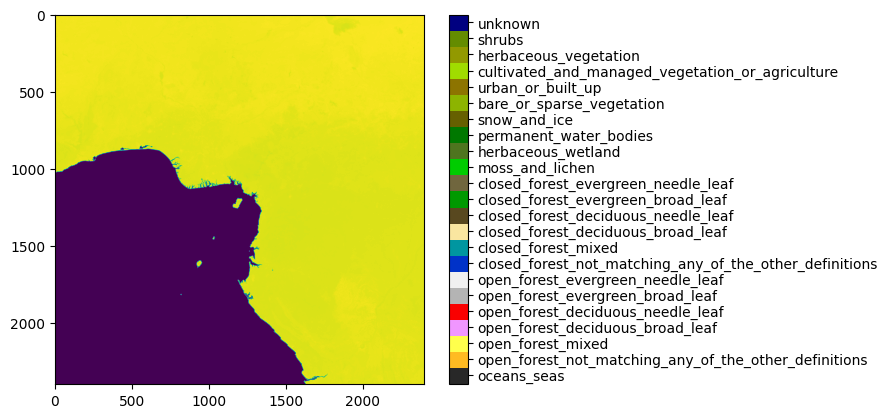

bbox POLYGON ((13.8124 8.7315, 13.8124 -1.2685, 3.8124 -1.2685, 3.8124 8.7315, 13.8124 8.7315))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1478343277.py:15: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=file, input_file = data, view=5) #6_28.7472, -16.504.png
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


200.tiff
0.0 15574.553
[[15244.9 15247.2 15247.1 ... 15399.2 15418.9 15439.6]
 [15254.8 15243.6 15240.  ... 15417.8 15419.2 15426.4]
 [15249.4 15255.  15227.1 ... 15431.8 15435.  15445.6]
 ...
 [    0.      0.      0.  ... 14936.1 14932.9 14938.9]
 [    0.      0.      0.  ... 14943.5 14942.2 14947.4]
 [    0.      0.      0.  ... 14954.4 14950.  14957.6]]


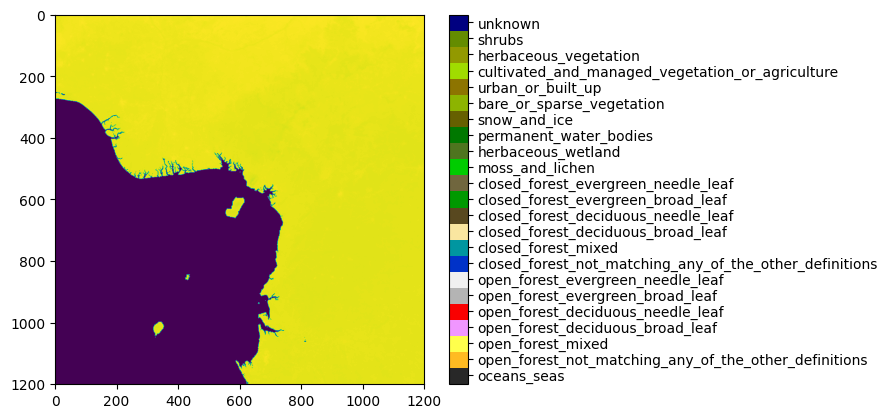

bbox POLYGON ((10.8124 5.7315, 10.8124 1.7315, 6.8124 1.7315, 6.8124 5.7315, 10.8124 5.7315))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1478343277.py:17: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=file, input_file = data, view=2) #6_28.7472, -16.504.png
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


200.tiff
0.0 15474.833
[[15128.1 15160.1 15179.1 ... 15107.8 15126.8 15117.4]
 [15176.  15211.6 15196.7 ... 15093.  15113.2 15095.4]
 [15228.  15244.4 15242.7 ... 15089.5 15095.8 15086.9]
 ...
 [    0.      0.      0.  ... 14865.8 14859.2 14891.1]
 [    0.      0.      0.  ... 14884.1 14875.9 14880.6]
 [    0.      0.      0.  ... 14877.5 14834.9 14831.9]]


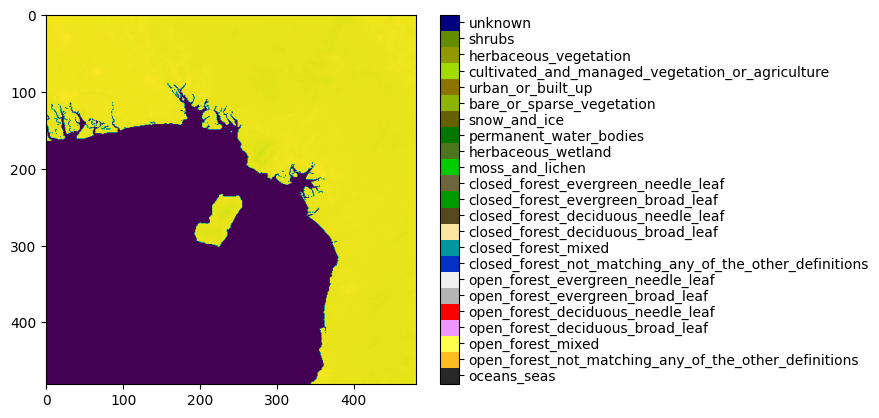

bbox POLYGON ((9.8124 4.7315, 9.8124 2.7315, 7.8124 2.7315, 7.8124 4.7315, 9.8124 4.7315))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1478343277.py:19: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=file, input_file = data, view=1) #6_28.7472, -16.504.png
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


200.tiff
0.0 15365.25
[[15086.9 15124.7 15130.2 ... 15013.2 15018.4 15016.2]
 [15108.7 15133.6 15133.5 ... 15002.8 15000.5 15004.7]
 [15085.1 15096.5 15131.2 ... 15011.9 15011.9 15007.8]
 ...
 [    0.      0.      0.  ...     0.      0.      0. ]
 [    0.      0.      0.  ...     0.      0.      0. ]
 [    0.      0.      0.  ...     0.      0.      0. ]]


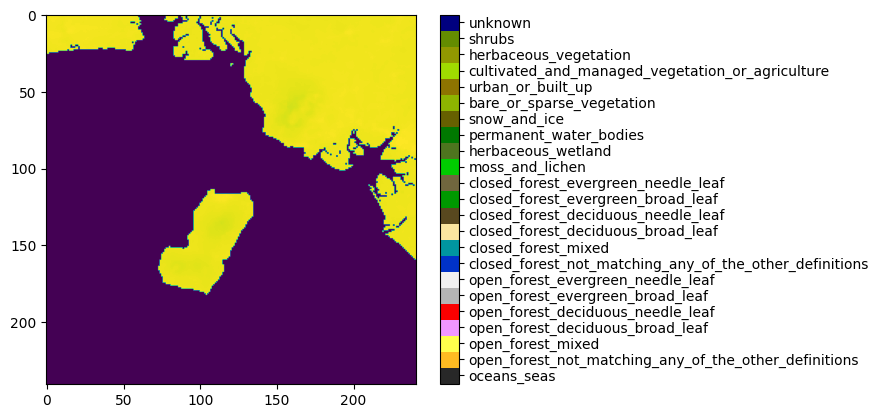

bbox POLYGON ((9.3124 4.2315, 9.3124 3.2315, 8.3124 3.2315, 8.3124 4.2315, 9.3124 4.2315))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1478343277.py:21: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=file, input_file = data, view=0.5) #6_28.7472, -16.504.png
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


200.tiff
0.0 15329.308
[[    0.      0.      0.  ... 14952.1 14999.9 15016.9]
 [    0.      0.      0.  ... 14946.  14993.5 15002.5]
 [    0.      0.      0.  ... 14990.4 15036.7 15039.5]
 ...
 [    0.      0.      0.  ...     0.      0.      0. ]
 [    0.      0.      0.  ...     0.      0.      0. ]
 [    0.      0.      0.  ...     0.      0.      0. ]]


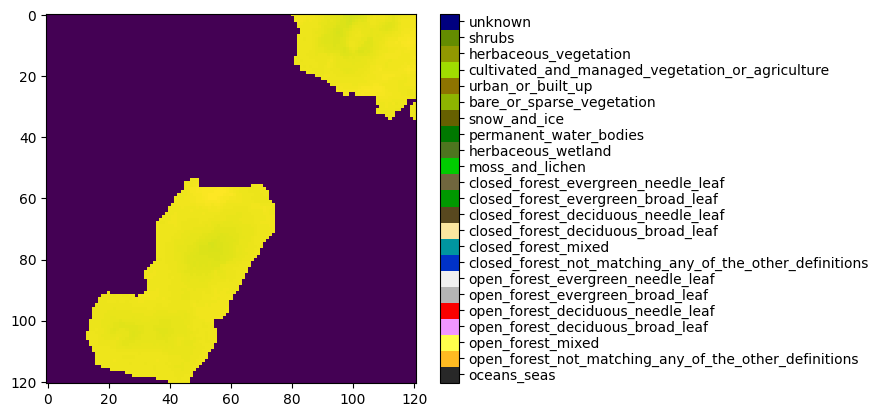

bbox POLYGON ((8.9124 3.8315, 8.9124 3.6315, 8.7124 3.6315, 8.7124 3.8315, 8.9124 3.8315))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1478343277.py:23: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=file, input_file = data, view=0.1) #6_28.7472, -16.504.png
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


200.tiff
0.0 15329.308
[[    0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.   

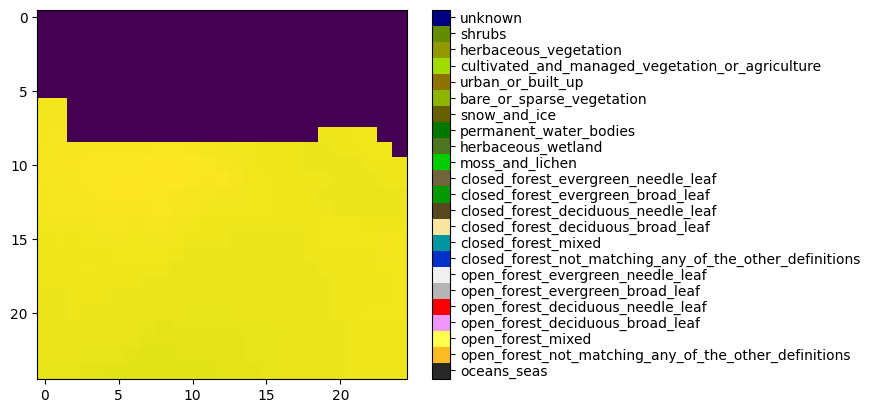

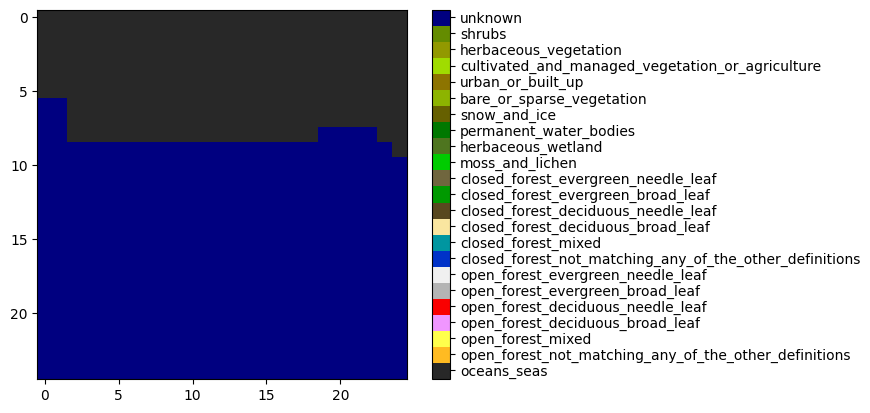

In [21]:
# file = "1_27.3348, -16.9727.png" 
# file = "2_27.3684, -17.479.png" 
# file = "100_27.2562, -16.7782.png"
file = "200_8.8124, 3.7315.png"  #Very good test by manual inspection, clearly on Malabo
# file = "210_31.379, 1.8387.png" # An ok test by manual inspection, we can see it is a bit northwest of lake victoria.


print(np.amin(data), np.amax(data))


generate_land_cover_image(satellite_image_name=file, input_file = data, view=2000) #6_28.7472, -16.504.png
show_land_cover(file)
generate_land_cover_image(satellite_image_name=file, input_file = data, view=10) #6_28.7472, -16.504.png
show_land_cover(file)
generate_land_cover_image(satellite_image_name=file, input_file = data, view=5) #6_28.7472, -16.504.png
show_land_cover(file)
generate_land_cover_image(satellite_image_name=file, input_file = data, view=2) #6_28.7472, -16.504.png
show_land_cover(file)
generate_land_cover_image(satellite_image_name=file, input_file = data, view=1) #6_28.7472, -16.504.png
show_land_cover(file)
generate_land_cover_image(satellite_image_name=file, input_file = data, view=0.5) #6_28.7472, -16.504.png
show_land_cover(file)
generate_land_cover_image(satellite_image_name=file, input_file = data, view=0.1) #6_28.7472, -16.504.png
show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data) #6_28.7472, -16.504.png
# show_land_cover(file)

In [15]:
import os

print(data)

dataset_list = os.listdir('dataset')
for image in dataset_list:
    if image == '.DS_Store':
        continue
    generate_land_cover_image(satellite_image_name=image, input_file = data)

<open DatasetReader name='dataPreprocessing/temperatureData/tiffTemperatureData/LST2016_avg.tiff' mode='r'>
bbox POLYGON ((27.2662 -16.7682, 27.2662 -16.7882, 27.2462 -16.7882, 27.2462 -16.7682, 27.2662 -16.7682))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.9785 -16.467, 27.9785 -16.487, 27.9585 -16.487, 27.9585 -16.467, 27.9785 -16.467))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.53 -17.113, 27.53 -17.133, 27.51 -17.133, 27.51 -17.113, 27.53 -17.113))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.4068 -16.2883, 28.4068 -16.3083, 28.3868 -16.3083, 28.3868 -16.2883, 28.4068 -16.2883))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.9125 -16.7366, 27.9125 -16.7566, 27.8925 -16.7566, 27.8925 -16.7366, 27.9125 -16.7366))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.3523 -15.7832, 28.3523 -15.8032, 28.3323 -15.8032, 28.3323 -15.7832, 28.3523 -15.7832))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.8812 -16.8028, 27.8812 -16.8228, 27.8612 -16.8228, 27.8612 -16.8028, 27.8812 -16.8028))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((28.8167 -16.1201, 28.8167 -16.1401, 28.7967 -16.1401, 28.7967 -16.1201, 28.8167 -16.1201))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

bbox POLYGON ((27.5798 -16.9216, 27.5798 -16.9416, 27.5598 -16.9416, 27.5598 -16.9216, 27.5798 -16.9216))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((27.6837 -16.9849, 27.6837 -17.0049, 27.6637 -17.0049, 27.6637 -16.9849, 27.6837 -16.9849))


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((26.9183 -16.9672, 26.9183 -16.9872, 26.8983 -16.9872, 26.8983 -16.9672, 26.9183 -16.9672))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

bbox POLYGON ((26.9205 -17.1493, 26.9205 -17.1693, 26.9005 -17.1693, 26.9005 -17.1493, 26.9205 -17.1493))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((27.4926 -17.1846, 27.4926 -17.2046, 27.4726 -17.2046, 27.4726 -17.1846, 27.4926 -17.1846))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

bbox POLYGON ((28.5273 -16.126, 28.5273 -16.146, 28.5073 -16.146, 28.5073 -16.126, 28.5273 -16.126))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((28.6129 -16.1847, 28.6129 -16.2047, 28.5929 -16.2047, 28.5929 -16.1847, 28.6129 -16.1847))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.5279 -16.6734, 27.5279 -16.6934, 27.5079 -16.6934, 27.5079 -16.6734, 27.5279 -16.6734))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

bbox POLYGON ((27.0565 -17.8143, 27.0565 -17.8343, 27.0365 -17.8343, 27.0365 -17.8143, 27.0565 -17.8143))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((26.7766 -17.259, 26.7766 -17.279, 26.7566 -17.279, 26.7566 -17.259, 26.7766 -17.259))


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((28.7058 -16.5086, 28.7058 -16.5286, 28.6858 -16.5286, 28.6858 -16.5086, 28.7058 -16.5086))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((27.5854 -16.572, 27.5854 -16.592, 27.5654 -16.592, 27.5654 -16.572, 27.5854 -16.572))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((27.514 -16.82, 27.514 -16.84, 27.494 

C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

bbox POLYGON ((12.6856 -1.8396, 12.6856 -1.8596, 12.6656 -1.8596, 12.6656 -1.8396, 12.6856 -1.8396))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((26.8039 -17.4982, 26.8039 -17.5182, 26.7839 -17.5182, 26.7839 -17.4982, 26.8039 -17.4982))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

bbox POLYGON ((27.738 -16.833, 27.738 -16.853, 27.718 -16.853, 27.718 -16.833, 27.738 -16.833))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((27.5677 -17.0479, 27.5677 -17.0679, 27.5477 -17.0679, 27.5477 -17.0479, 27.5677 -17.0479))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

bbox POLYGON ((27.3734 -17.1297, 27.3734 -17.1497, 27.3534 -17.1497, 27.3534 -17.1297, 27.3734 -17.1297))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.4101 -17.2278, 27.4101 -17.2478, 27.3901 -17.2478, 27.3901 -17.2278, 27.4101 -17.2278))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((27.1042 -17.4945, 27.1042 -17.5145, 27.0842 -17.5145, 27.0842 -17.4945, 27.1042 -17.4945))


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((27.2659 -16.7597, 27.2659 -16.7797, 27.2459 -16.7797, 27.2459 -16.7597, 27.2659 -16.7597))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.9824 -16.4745, 27.9824 -16.4945, 27.9624 -16.4945, 27.9624 -16.4745, 27.9824 -16.4745))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.5326 -17.1175, 27.5326 -17.1375, 27.5126 -17.1375, 27.5126 -17.1175, 27.5326 -17.1175))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.4061 -16.2891, 28.4061 -16.3091, 28.3861 -16.3091, 28.3861 -16.2891, 28.4061 -16.2891))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((12.6856 -1.8396, 12.6856 -1.8596, 12.6656 -1.8596, 12.6656 -1.8396, 12.6856 -1.8396))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.9089 -16.7387, 27.9089 -16.7587, 27.8889 -16.7587, 27.8889 -16.7387, 27.9089 -16.7387))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.3605 -15.7941, 28.3605 -15.8141, 28.3405 -15.8141, 28.3405 -15.7941, 28.3605 -15.7941))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.8893 -16.7982, 27.8893 -16.8182, 27.8693 -16.8182, 27.8693 -16.7982, 27.8893 -16.7982))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.8182 -16.1226, 28.8182 -16.1426, 28.7982 -16.1426, 28.7982 -16.1226, 28.8182 -16.1226))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((27.5884 -16.9079, 27.5884 -16.9279, 27.5684 -16.9279, 27.5684 -16.9079, 27.5884 -16.9079))


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((27.6896 -16.9812, 27.6896 -17.0012, 27.6696 -17.0012, 27.6696 -16.9812, 27.6896 -16.9812))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((26.9314 -17.1413, 26.9314 -17.1613, 26.9114 -17.1613, 26.9114 -17.1413, 26.9314 -17.1413))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.4955 -17.184, 27.4955 -17.204, 27.4755 -17.204, 27.4755 -17.184, 27.4955 -17.184))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.1123 -16.7407, 27.1123 -16.7607, 27.0923 -16.7607, 27.0923 -16.7407, 27.1123 -16.7407))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.5275 -16.1266, 28.5275 -16.1466, 28.5075 -16.1466, 28.5075 -16.1266, 28.5275 -16.1266))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.126 -16.5983, 28.126 -16.6183, 28.106 -16.6183, 28.106 -16.5983, 28.126 -16.5983))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.6063 -16.188, 28.6063 -16.208, 28.5863 -16.208, 28.5863 -16.188, 28.6063 -16.188))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.547 -16.6769, 27.547 -16.6969, 27.527 -16.6969, 27.527 -16.6769, 27.547 -16.6769))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.0237 -17.8182, 27.0237 -17.8382, 27.0037 -17.8382, 27.0037 -17.8182, 27.0237 -17.8182))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((26.7816 -17.2636, 26.7816 -17.2836, 26.7616 -17.2836, 26.7616 -17.2636, 26.7816 -17.2636))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.7038 -16.5077, 28.7038 -16.5277, 28.6838 -16.5277, 28.6838 -16.5077, 28.7038 -16.5077))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.5908 -16.5635, 27.5908 -16.5835, 27.5708 -16.5835, 27.5708 -16.5635, 27.5908 -16.5635))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.5111 -16.8123, 27.5111 -16.8323, 27.4911 -16.8323, 27.4911 -16.8123, 27.5111 -16.8123))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.154 -16.6028, 28.154 -16.6228, 28.134 -16.6228, 28.134 -16.6028, 28.154 -16.6028))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((26.6115 -17.3986, 26.6115 -17.4186, 26.5915 -17.4186, 26.5915 -17.3986, 26.6115 -17.3986))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.2336 -17.3501, 27.2336 -17.3701, 27.2136 -17.3701, 27.2136 -17.3501, 27.2336 -17.3501))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((26.6305 -17.3887, 26.6305 -17.4087, 26.6105 -17.4087, 26.6105 -17.3887, 26.6305 -17.3887))


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((28.397 -16.4772, 28.397 -16.4972, 28.377 -16.4972, 28.377 -16.4772, 28.397 -16.4772))


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((26.8254 -17.7187, 26.8254 -17.7387, 26.8054 -17.7387, 26.8054 -17.7187, 26.8254 -17.7187))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((26.9297 -17.2891, 26.9297 -17.3091, 26.9097 -17.3091, 26.9097 -17.2891, 26.9297 -17.2891))


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((27.1047 -17.1602, 27.1047 -17.1802, 27.0847 -17.1802, 27.0847 -17.1602, 27.1047 -17.1602))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((27.0949 -17.2658, 27.0949 -17.2858, 27.0749 -17.2858, 27.0749 -17.2658, 27.0949 -17.2658))


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((28.7382 -16.3884, 28.7382 -16.4084, 28.7182 -16.4084, 28.7182 -16.3884, 28.7382 -16.3884))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((27.1045 -16.87, 27.1045 -16.89, 27.0845 -16.89, 27.0845 -16.87, 27.1045 -16.87))


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((28.3967 -15.9379, 28.3967 -15.9579, 28.3767 -15.9579, 28.3767 -15.9379, 28.3967 -15.9379))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.8678 -16.3753, 27.8678 -16.3953, 27.8478 -16.3953, 27.8478 -16.3753, 27.8678 -16.3753))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.4373 -16.7972, 27.4373 -16.8172, 27.4173 -16.8172, 27.4173 -16.7972, 27.4373 -16.7972))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.231 -17.3494, 27.231 -17.3694, 27.211 -17.3694, 27.211 -17.3494, 27.231 -17.3494))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.7612 -16.01, 28.7612 -16.03, 28.7412 -16.03, 28.7412 -16.01, 28.7612 -16.01))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.445 -16.5387, 28.445 -16.5587, 28.425 -16.5587, 28.425 -16.5387, 28.445 -16.5387))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.8192 -16.6284, 27.8192 -16.6484, 27.7992 -16.6484, 27.7992 -16.6284, 27.8192 -16.6284))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.3214 -16.6692, 27.3214 -16.6892, 27.3014 -16.6892, 27.3014 -16.6692, 27.3214 -16.6692))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((28.5434 -16.4519, 28.5434 -16.4719, 28.5234 -16.4719, 28.5234 -16.4519, 28.5434 -16.4519))


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((26.9211 -17.0474, 26.9211 -17.0674, 26.9011 -17.0674, 26.9011 -17.0474, 26.9211 -17.0474))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.0383 -16.3076, 28.0383 -16.3276, 28.0183 -16.3276, 28.0183 -16.3076, 28.0383 -16.3076))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.3 -15.8598, 28.3 -15.8798, 28.28 -15.8798, 28.28 -15.8598, 28.3 -15.8598))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.3884 -16.7459, 27.3884 -16.7659, 27.3684 -16.7659, 27.3684 -16.7459, 27.3884 -16.7459))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.1036 -16.4687, 28.1036 -16.4887, 28.0836 -16.4887, 28.0836 -16.4687, 28.1036 -16.4687))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.4039 -16.4738, 28.4039 -16.4938, 28.3839 -16.4938, 28.3839 -16.4738, 28.4039 -16.4738))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.0802 -17.6554, 27.0802 -17.6754, 27.0602 -17.6754, 27.0602 -17.6554, 27.0802 -17.6554))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.3626 -16.9588, 27.3626 -16.9788, 27.3426 -16.9788, 27.3426 -16.9588, 27.3626 -16.9588))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.3693 -17.48, 27.3693 -17.5, 27.3493 -17.5, 27.3493 -17.48, 27.3693 -17.48))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.2984 -16.3874, 28.2984 -16.4074, 28.2784 -16.4074, 28.2784 -16.3874, 28.2984 -16.3874))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.289 -17.4229, 27.289 -17.4429, 27.269 -17.4429, 27.269 -17.4229, 27.289 -17.4229))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((28.7585 -16.4932, 28.7585 -16.5132, 28.7385 -16.5132, 28.7385 -16.4932, 28.7585 -16.4932))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.2493 -16.9273, 27.2493 -16.9473, 27.2293 -16.9473, 27.2293 -16.9273, 27.2493 -16.9273))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.3578 -17.335, 27.3578 -17.355, 27.3378 -17.355, 27.3378 -17.335, 27.3578 -17.335))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.045 -17.0652, 27.045 -17.0852, 27.025 -17.0852, 27.025 -17.0652, 27.045 -17.0652))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((26.9011 -16.9694, 26.9011 -16.9894, 26.8811 -16.9894, 26.8811 -16.9694, 26.9011 -16.9694))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((26.8029 -17.7117, 26.8029 -17.7317, 26.7829 -17.7317, 26.7829 -17.7117, 26.8029 -17.7117))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((26.8176 -17.5018, 26.8176 -17.5218, 26.7976 -17.5218, 26.7976 -17.5018, 26.8176 -17.5018))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.7327 -16.8171, 27.7327 -16.8371, 27.7127 -16.8371, 27.7127 -16.8171, 27.7327 -16.8171))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.565 -17.0475, 27.565 -17.0675, 27.545 -17.0675, 27.545 -17.0475, 27.565 -17.0475))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.3679 -17.1284, 27.3679 -17.1484, 27.3479 -17.1484, 27.3479 -17.1284, 27.3679 -17.1284))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((27.4182 -17.2302, 27.4182 -17.2502, 27.3982 -17.2502, 27.3982 -17.2302, 27.4182 -17.2302))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

bbox POLYGON ((27.1288 -17.485, 27.1288 -17.505, 27.1088 -17.505, 27.1088 -17.485, 27.1288 -17.485))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((-4.171 5.971, -4.171 5.951, -4.191 5.951, -4.191 5.971, -4.171 5.971))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

bbox POLYGON ((8.8006 3.7614, 8.8006 3.7414, 8.7806 3.7414, 8.7806 3.7614, 8.8006 3.7614))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((8.8095 3.7608, 8.8095 3.7408, 8.7895 3.7408, 8.7895 3.7608, 8.8095 3.7608))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

bbox POLYGON ((8.7961 3.7666, 8.7961 3.7466, 8.7761 3.7466, 8.7761 3.7666, 8.7961 3.7666))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((26.9243 -17.3114, 26.9243 -17.3314, 26.9043 -17.3314, 26.9043 -17.3114, 26.9243 -17.3114))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

bbox POLYGON ((8.7872 3.7613, 8.7872 3.7413, 8.7672 3.7413, 8.7672 3.7613, 8.7872 3.7613))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((8.7952 3.7404, 8.7952 3.7204, 8.7752 3.7204, 8.7752 3.7404, 8.7952 3.7404))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((8.7852 3.7503, 8.7852 3.7303, 8.7652 3.7303, 8.7652 3.7503, 8.7852 3.7503))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((8.7752 3.746, 8.7752 3.726, 8.7552 3.726, 8.7552 3.746, 8.7752 3.746))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((8.7762 3.7548, 8.7762 3.7348, 8.7562 3.7348, 8.7562 3.7548, 8.7762 3.7548))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((8.7843 3.7432, 8.7843 3.7232, 8.7643 3.7232, 8.7643 3.7432, 8.7843 3.7432))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((8.7724 3.7375, 8.7724 3.7175, 8.7524 3.7175, 8.7524 3.7375, 8.7724 3.7375))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((8.7933 3.7593, 8.7933 3.7393, 8.7733 3.7393, 8.7733 3.7593, 8.7933 3.7593))


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((8.8001 3.7555, 8.8001 3.7355, 8.7801 3.7355, 8.7801 3.7555, 8.8001 3.7555))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((8.7967 3.7485, 8.7967 3.7285, 8.7767 3.7285, 8.7767 3.7485, 8.7967 3.7485))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.106 -17.1496, 27.106 -17.1696, 27.086 -17.1696, 27.086 -17.1496, 27.106 -17.1496))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.3448 -16.9627, 27.3448 -16.9827, 27.3248 -16.9827, 27.3248 -16.9627, 27.3448 -16.9627))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((8.8224 3.7415, 8.8224 3.7215, 8.8024 3.7215, 8.8024 3.7415, 8.8224 3.7415))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((8.8455 3.7377, 8.8455 3.7177, 8.8255 3.7177, 8.8255 3.7377, 8.8455 3.7377))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((8.5153 3.4565, 8.5153 3.4365, 8.4953 3.4365, 8.4953 3.4565, 8.5153 3.4565))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((8.5737 3.4227, 8.5737 3.4027, 8.5537 3.4027, 8.5537 3.4227, 8.5737 3.4227))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((8.5638 3.4691, 8.5638 3.4491, 8.5438 3.4491, 8.5438 3.4691, 8.5638 3.4691))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((8.9045 3.6232, 8.9045 3.6032, 8.8845 3.6032, 8.8845 3.6232, 8.9045 3.6232))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((8.9187 3.7118, 8.9187 3.6918, 8.8987 3.6918, 8.8987 3.7118, 8.9187 3.7118))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((8.7801 3.7645, 8.7801 3.7445, 8.7601 3.7445, 8.7601 3.7645, 8.7801 3.7645))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((8.6958 3.7311, 8.6958 3.7111, 8.6758 3.7111, 8.6758 3.7311, 8.6958 3.7311))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((31.4225 1.9101, 31.4225 1.8901, 31.4025 1.8901, 31.4025 1.9101, 31.4225 1.9101))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((27.0974 -17.268, 27.0974 -17.288, 27.0774 -17.288, 27.0774 -17.268, 27.0974 -17.268))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((31.389 1.8487, 31.389 1.8287, 31.369 1.8287, 31.369 1.8487, 31.389 1.8487))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((31.32 1.7405, 31.32 1.7205, 31.3 1.7205, 31.3 1.7405, 31.32 1.7405))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((31.4306 1.7686, 31.4306 1.7486, 31.4106 1.7486, 31.4106 1.7686, 31.4306 1.7686))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((31.4576 1.7448, 31.4576 1.7248, 31.4376 1.7248, 31.4376 1.7448, 31.4576 1.7448))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((-13.4978 16.1606, -13.4978 16.1406, -13.5178 16.1406, -13.5178 16.1606, -13.4978 16.1606))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((-13.4978 16.1606, -13.4978 16.1406, -13.5178 16.1406, -13.5178 16.1606, -13.4978 16.1606))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((-5.6308 9.4714, -5.6308 9.4514, -5.6508 9.4514, -5.6508 9.4714, -5.6308 9.4714))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((-5.6308 9.4714, -5.6308 9.4514, -5.6508 9.4514, -5.6508 9.4714, -5.6308 9.4714))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((-5.0265 7.7022, -5.0265 7.6822, -5.0465 7.6822, -5.0465 7.7022, -5.0265 7.7022))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


bbox POLYGON ((-5.0265 7.7022, -5.0265 7.6822, -5.0465 7.6822, -5.0465 7.7022, -5.0265 7.7022))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((28.738 -16.3816, 28.738 -16.4016, 28.718 -16.4016, 28.718 -16.3816, 28.738 -16.3816))


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-pa

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}
bbox POLYGON ((28.8236 -9.3892, 28.8236 -9.4092, 28.8036 -9.4092, 28.8036 -9.3892, 28.8236 -9.3892))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9063, 'height': 9131, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332585013, 0.0, -21.5166666647345,
       0.0, -0.008333333332585013, 39.09999999648888)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_6844\1995989658.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


KeyboardInterrupt: 

In [ ]:
#Test
from PIL import Image
for i in range(263):

    im = Image.open('landcover/' + str(i+1) + '.tiff')
    imarray = np.array(im)
#     if imarray.shape[0] > 10:
#         print(i+1)
#         continue
    print(i+1, imarray)